In [1]:
import numpy as np
from sklearn.metrics import euclidean_distances
import pandas as pd
import minisom
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from random import randint, choice
import LVQ

In [2]:
data = pd.read_csv(r"../data/SD-2X_rocktype.csv")
x = data.iloc[:, 0:6].values
y = data.iloc[:, 6].values
y [y==4] = 0
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=44)

# use Minmaxscaler because we use euclidean distance
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

C:\Users\Thend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
epsilon = 0.9
epsilon_dec_factor = 0.001

In [4]:
# Training the SOM
from minisom import MiniSom
som1 = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som1.random_weights_init(x_train)
som1.train_random(data = x_train, num_iteration = 100)

In [5]:
labels = np.zeros((4, 10, 10))

In [6]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som1.distance_map().T)
colorbar()
markers = ['1', '2', '3', '4', 's', '8', 'p', '>']
colors = ['r', 'g', 'b', 'y', 'w', 'c', 'm', 'k']
for i, x in enumerate(x_train):
    w = som1.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y_train[i]],
         markeredgecolor = colors[y_train[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
    if y_train[i] == 0:
        labels[0, w[0], w[1]] += 1
    elif y_train[i] == 1:
        labels[1, w[0], w[1]] += 1
    elif y_train[i] == 2:
        labels[2, w[0], w[1]] += 1
    elif y_train[i] == 3:
        labels[3, w[0], w[1]] += 1
show()

<Figure size 640x480 with 2 Axes>

In [7]:
taggings = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        tmp = np.array([labels[0][i][j], labels[1][i][j], labels[2][i][j], labels[3][i][j]])
        sort = tmp.argsort()
        if (tmp[sort[3]]/tmp[sort[2]] < 5):
            taggings[i][j] = np.random.choice([sort[3], sort[2]])
        else:
            taggings[i][j] = sort[3]

C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [8]:
p_vectors = []
for i in range(10):
    for j in range(10):
        if(taggings[i][j] == 0):
            p = LVQ.prototype(0, som1.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 1):
            p = LVQ.prototype(1, som1.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 2):
            p = LVQ.prototype(2, som1.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 3):
            p = LVQ.prototype(3, som1.weights[(i,j)], epsilon)
            p_vectors.append(p)
print("class id \t Initial prototype vector \n")
for p_v in p_vectors:
    print(p_v.class_id, '\t', p_v.p_vector)

class id 	 Initial prototype vector 

3 	 [0.11721957 0.28217419 0.71832283 0.40662045 0.10668685 0.4625228 ]
1 	 [0.15673202 0.36153978 0.31403832 0.53644978 0.09970099 0.66961582]
2 	 [0.21798924 0.36985795 0.55270009 0.47542603 0.2280974  0.48181954]
3 	 [0.16264968 0.30166838 0.69236379 0.38732606 0.17428293 0.47199326]
3 	 [0.32123413 0.49639851 0.46612334 0.46029754 0.28243014 0.37614569]
3 	 [0.35115119 0.54052364 0.39054072 0.48738926 0.32976345 0.29276742]
0 	 [0.35578031 0.45224301 0.46043539 0.46058912 0.44891407 0.20791755]
0 	 [0.39784757 0.38838607 0.39871493 0.45563311 0.56463098 0.07409656]
0 	 [0.38971292 0.36555791 0.47538541 0.45713222 0.52387786 0.07128878]
3 	 [0.37326408 0.36422533 0.35735924 0.58837641 0.32712877 0.38354684]
3 	 [0.29964008 0.41868546 0.37433645 0.55900856 0.31918229 0.42476184]
2 	 [0.15502848 0.29888657 0.62681168 0.43845605 0.13909133 0.53117794]
0 	 [0.10748288 0.19026354 0.86869653 0.26265168 0.11213764 0.34066523]
0 	 [0.17726397 0.29452768

In [9]:
lvq1 = LVQ.LVQ(x_train, y_train, n_classes=2, n_neurons=25, p_vectors=p_vectors, epsilon=0.9, epsilon_dec_factor=0.001)
neurons = lvq1.fit(x_train, y_train)

In [10]:
predicted_y1 = [lvq1.predict(instance) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y1, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.97      0.92      0.94       138
          1       0.92      0.87      0.90        55
          2       0.67      0.43      0.52        28
          3       0.80      0.94      0.86       108

avg / total       0.88      0.88      0.87       329



In [11]:
data_new = pd.read_csv(r"../data/SD-3X_rocktype.csv")
x_new = data.iloc[:, 0:6].values
y_new = data.iloc[:, 6].values
y_new[y_new == 4] = 0
x_new = minmax.fit_transform(x_new)
predicted_y_new = [lvq1.predict(instance) for instance in x_new]

from sklearn.metrics import classification_report

print (classification_report(y_new, predicted_y_new, target_names=['0', '1', '2', '3']))

             precision    recall  f1-score   support

          0       0.98      0.91      0.94       558
          1       0.81      0.90      0.85       165
          2       0.66      0.35      0.45       139
          3       0.80      0.94      0.86       453

avg / total       0.86      0.86      0.85      1315



In [12]:
# Training the SOM
from minisom import MiniSom
som2 = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som2.random_weights_init(x_train)
som2.train_random(data = x_train, num_iteration = 100)

In [13]:
labels = np.zeros((4, 10, 10))

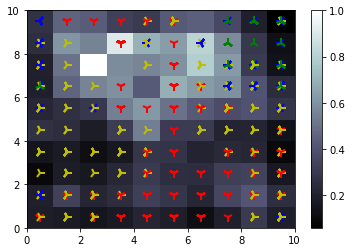

In [14]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som2.distance_map().T)
colorbar()
markers = ['1', '2', '3', '4', 's', '8', 'p', '>']
colors = ['r', 'g', 'b', 'y', 'w', 'c', 'm', 'k']
for i, x in enumerate(x_train):
    w = som2.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y_train[i]],
         markeredgecolor = colors[y_train[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
    if y_train[i] == 0:
        labels[0, w[0], w[1]] += 1
    elif y_train[i] == 1:
        labels[1, w[0], w[1]] += 1
    elif y_train[i] == 2:
        labels[2, w[0], w[1]] += 1
    elif y_train[i] == 3:
        labels[3, w[0], w[1]] += 1
show()

In [15]:
taggings = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        tmp = np.array([labels[0][i][j], labels[1][i][j], labels[2][i][j], labels[3][i][j]])
        sort = tmp.argsort()
        if (tmp[sort[3]]/tmp[sort[2]] < 5):
            taggings[i][j] = np.random.choice([sort[3], sort[2]])
        else:
            taggings[i][j] = sort[3]

C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [16]:
p_vectors = []
for i in range(10):
    for j in range(10):
        if(taggings[i][j] == 0):
            p = LVQ.prototype(0, som2.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 1):
            p = LVQ.prototype(1, som2.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 2):
            p = LVQ.prototype(2, som2.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 3):
            p = LVQ.prototype(3, som2.weights[(i,j)], epsilon)
            p_vectors.append(p)
print("class id \t Initial prototype vector \n")
for p_v in p_vectors:
    print(p_v.class_id, '\t', p_v.p_vector)

class id 	 Initial prototype vector 

0 	 [0.36824086 0.48069284 0.43144274 0.50071048 0.37247268 0.24029845]
2 	 [0.35064299 0.45125542 0.33808336 0.59338263 0.22457348 0.39570378]
3 	 [0.3743473  0.46375789 0.32294396 0.5881058  0.2617715  0.35511571]
3 	 [0.38739079 0.44595069 0.33145476 0.56878284 0.3259602  0.33381152]
3 	 [0.32919314 0.43329058 0.4583153  0.50599956 0.24411882 0.4221477 ]
3 	 [0.33483964 0.45287494 0.34116897 0.49111643 0.21848452 0.52674435]
2 	 [0.31378953 0.44232218 0.40720885 0.46787862 0.18943058 0.53411031]
2 	 [0.32026765 0.41271662 0.42620996 0.50364102 0.24370725 0.4820697 ]
2 	 [0.29958702 0.36957296 0.48591003 0.51623823 0.27746357 0.4405303 ]
2 	 [0.17982603 0.31800594 0.50336163 0.50917244 0.18354894 0.56587552]
3 	 [0.37381397 0.45823304 0.36661012 0.57905719 0.2839545  0.31614115]
0 	 [0.33903394 0.44969305 0.43516748 0.57054206 0.25192079 0.32323223]
3 	 [0.36801023 0.4592638  0.33439893 0.59693312 0.25814599 0.34475221]
3 	 [0.38170374 0.45526709

In [17]:
lvq2 = LVQ.LVQ(x_train, y_train, n_classes=2, n_neurons=25, p_vectors=p_vectors, epsilon=0.9, epsilon_dec_factor=0.001)
neurons = lvq2.fit(x_train, y_train)

In [18]:
predicted_y2 = [lvq2.predict(instance) for instance in x_new]

from sklearn.metrics import classification_report

print (classification_report(y_new, predicted_y2, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.99      0.92      0.95       558
          1       0.90      0.85      0.87       165
          2       0.62      0.43      0.51       139
          3       0.78      0.92      0.84       453

avg / total       0.86      0.86      0.86      1315



In [19]:
# Training the SOM
from minisom import MiniSom
som3 = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som3.random_weights_init(x_train)
som3.train_random(data = x_train, num_iteration = 100)

In [20]:
labels = np.zeros((4, 10, 10))

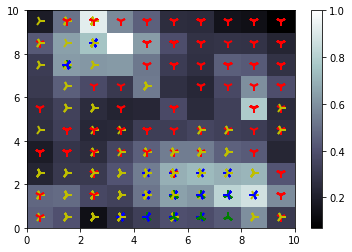

In [21]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som3.distance_map().T)
colorbar()
markers = ['1', '2', '3', '4', 's', '8', 'p', '>']
colors = ['r', 'g', 'b', 'y', 'w', 'c', 'm', 'k']
for i, x in enumerate(x_train):
    w = som3.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y_train[i]],
         markeredgecolor = colors[y_train[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
    if y_train[i] == 0:
        labels[0, w[0], w[1]] += 1
    elif y_train[i] == 1:
        labels[1, w[0], w[1]] += 1
    elif y_train[i] == 2:
        labels[2, w[0], w[1]] += 1
    elif y_train[i] == 3:
        labels[3, w[0], w[1]] += 1
show()

In [22]:
taggings = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        tmp = np.array([labels[0][i][j], labels[1][i][j], labels[2][i][j], labels[3][i][j]])
        sort = tmp.argsort()
        if (tmp[sort[3]]/tmp[sort[2]] < 5):
            taggings[i][j] = np.random.choice([sort[3], sort[2]])
        else:
            taggings[i][j] = sort[3]

C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Thend\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [23]:
taggings

array([[0., 3., 3., 0., 3., 0., 3., 3., 3., 3.],
       [3., 3., 3., 0., 0., 3., 3., 3., 3., 0.],
       [3., 3., 3., 0., 0., 3., 0., 3., 2., 0.],
       [2., 3., 3., 0., 3., 0., 0., 3., 3., 0.],
       [2., 2., 3., 0., 0., 3., 3., 0., 0., 0.],
       [1., 3., 3., 3., 0., 0., 3., 0., 0., 0.],
       [1., 2., 3., 3., 3., 3., 0., 0., 0., 0.],
       [1., 1., 3., 3., 3., 3., 0., 0., 0., 0.],
       [3., 2., 3., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 3., 3., 3., 0., 0., 0., 0.]])

In [24]:
p_vectors = []
for i in range(10):
    for j in range(10):
        if(taggings[i][j] == 0):
            p = LVQ.prototype(0, som3.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 1):
            p = LVQ.prototype(1, som3.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 2):
            p = LVQ.prototype(2, som3.weights[(i,j)], epsilon)
            p_vectors.append(p)
        elif(taggings[i][j] == 3):
            p = LVQ.prototype(3, som3.weights[(i,j)], epsilon)
            p_vectors.append(p)
print("class id \t Initial prototype vector \n")
for p_v in p_vectors:
    print(p_v.class_id, '\t', p_v.p_vector)

class id 	 Initial prototype vector 

0 	 [0.33374789 0.35746511 0.6015638  0.49141472 0.25943913 0.30025813]
3 	 [0.42147297 0.42355171 0.43521396 0.52410285 0.35633068 0.22781123]
3 	 [0.37935063 0.47217003 0.34269772 0.54022852 0.37229615 0.29198555]
0 	 [0.38466417 0.44715188 0.34053281 0.53312197 0.44389037 0.23424001]
3 	 [0.36160583 0.41603244 0.43911579 0.52216555 0.40376104 0.26010712]
0 	 [0.3683283  0.39187142 0.50573944 0.50958783 0.37534651 0.23331076]
3 	 [0.40020453 0.38239931 0.50645781 0.50889229 0.34613688 0.24150669]
3 	 [0.34631073 0.34696647 0.5871999  0.48035092 0.27002445 0.33351043]
3 	 [0.35709515 0.37679537 0.49677171 0.51676674 0.32823717 0.33005859]
3 	 [0.34723811 0.33551932 0.60391678 0.45157792 0.27678898 0.34871513]
3 	 [0.37309802 0.43163384 0.3072119  0.59520469 0.27633238 0.38662998]
3 	 [0.37256903 0.45629216 0.30309239 0.5787348  0.33037373 0.34211695]
3 	 [0.38106788 0.4506128  0.31851611 0.55507571 0.40461566 0.2801071 ]
0 	 [0.37094039 0.45809504

In [25]:
lvq3 = LVQ.LVQ(x_train, y_train, n_classes=2, n_neurons=25, p_vectors=p_vectors, epsilon=0.9, epsilon_dec_factor=0.001)
neurons = lvq3.fit(x_train, y_train)

In [26]:
predicted_y3 = [lvq3.predict(instance) for instance in x_new]

from sklearn.metrics import classification_report

print (classification_report(y_new, predicted_y3, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.98      0.89      0.93       558
          1       0.82      0.82      0.82       165
          2       0.45      0.18      0.26       139
          3       0.74      0.96      0.83       453

avg / total       0.82      0.83      0.81      1315



In [27]:
ensemble = [np.asarray(predicted_y_new), np.asarray(predicted_y2), np.asarray(predicted_y3)]

In [28]:
len(ensemble[0])

1315

In [29]:
predict = [np.bincount([ensemble[j][i] for j in range(3)]).argmax() for i in range(len(ensemble[1]))]

In [30]:
print (classification_report(y_new, predict, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.98      0.91      0.94       558
          1       0.84      0.90      0.87       165
          2       0.71      0.35      0.46       139
          3       0.78      0.95      0.86       453

avg / total       0.87      0.86      0.85      1315



In [31]:
for i in range(0,4):
    print("# of " + str(i) +  ": ", len(y_train[y_train==i]))

# of 0:  420
# of 1:  110
# of 2:  111
# of 3:  345
